# Telco Customer Retention & Churn Analysis

Customer churn—the rate at which subscribers cancel their service—directly affects recurring revenue in subscription businesses.
This project uses a real Telco dataset to explore churn patterns and identify key drivers of customer retention

### 1. Project Overview

- **Business Context**

A telecom company wants to understand why customers leave (“churn”) and how to reduce it.

- **Goal**

Create a clean SQLite database from the raw Telco churn dataset and perform intermediate–advanced SQL queries to uncover churn drivers and revenue impacts.

- **Deliverable**

A self-contained telco_churn.db SQLite database, SQL scripts, and a README summarizing insights.

### 2. Data Source

- **Original File**: Telco_Customer_Churn.csv

- **Key Columns** :
customerID, gender, SeniorCitizen, Partner, Dependents,
tenure, Contract, InternetService, PaymentMethod,
MonthlyCharges, TotalCharges, Churn

### 3. Data Cleaning & Preparation


#### 3.1 Data Cleaning


In [2]:
import pandas as pd
import numpy as np

raw_path = "Telco_Customer_Churn.csv"

In [3]:
df_raw = pd.read_csv(raw_path)

print("Initial shape:", df_raw.shape)
df_raw.head()

Initial shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Check column data types and missing values
df_raw.info()
df_raw.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

TotalCharges shows as object even though it should be numeric

In [5]:
# How many rows cannot be converted to a number?
invalid_total = pd.to_numeric(df_raw["TotalCharges"], errors="coerce").isna().sum()
print(f"Rows with non-numeric TotalCharges: {invalid_total}")

Rows with non-numeric TotalCharges: 11


In [6]:
# Inspect the Problem Rows
df_raw[pd.to_numeric(df_raw["TotalCharges"], errors="coerce").isna()].head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No


New customers (tenure = 0) may have no billed total yet, so the CSV contains empty strings instead of numbers.

In [7]:
# Setting to 0 to prevent errors in SQLite
df_raw["TotalCharges"] = pd.to_numeric(df_raw["TotalCharges"], errors="coerce")
df_raw.loc[(df_raw["tenure"] == 0) & (df_raw["TotalCharges"].isna()), "TotalCharges"] = 0

In [8]:
# Remove leading/trailing spaces in all string columns
for col in df_raw.select_dtypes(include="object").columns:
    df_raw[col] = df_raw[col].str.strip()

In [9]:
# Convert numeric columns explicitly for SQLite
df_raw["tenure"] = df_raw["tenure"].astype(int)
df_raw["MonthlyCharges"] = df_raw["MonthlyCharges"].astype(float)
df_raw["TotalCharges"] = df_raw["TotalCharges"].astype(float)

In [10]:
# Confirm no missing values remain
print(df_raw.isna().sum())

# Check dtypes
df_raw.info()

# Quick look at cleaned data
df_raw.head()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   obj

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### 3.2 Export

In [11]:
# Export Cleaned Data
clean_path = "cleaned_telco.csv"
df_raw.to_csv(clean_path, index=False)
print(f"Cleaned dataset saved to: {clean_path}")

Cleaned dataset saved to: cleaned_telco.csv


### 5. Analysis & Queries

In [12]:
df = pd.read_csv("cleaned_telco.csv")

In [13]:
import sqlite3
conn = sqlite3.connect("telco_churn.db")
df.to_sql("Customers", conn, if_exists="replace", index=False)

7043

#### 5.1 Verify the Table

In [14]:
# Count rows to confirm successful load
pd.read_sql("SELECT COUNT(*) AS row_count FROM Customers;", conn)

,row_count
0,7043


In [15]:
# View first few rows
pd.read_sql("SELECT * FROM Customers LIMIT 5;", conn)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [16]:
# See table schema
pd.read_sql("PRAGMA table_info(Customers);", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,customerID,TEXT,0,None,0
1,1,gender,TEXT,0,None,0
2,2,SeniorCitizen,INTEGER,0,None,0
3,3,Partner,TEXT,0,None,0
4,4,Dependents,TEXT,0,None,0
5,5,tenure,INTEGER,0,None,0
6,6,PhoneService,TEXT,0,None,0
7,7,MultipleLines,TEXT,0,None,0
8,8,InternetService,TEXT,0,None,0
9,9,OnlineSecurity,TEXT,0,None,0


#### 5.2 Analysis

**How many customers have churned?**

In [37]:
# How many customers have churned?
pd.read_sql("""
SELECT Churn, COUNT(*) AS count
FROM Customers
GROUP BY Churn;
""", conn)

,Churn,count
0,No,5174
1,Yes,1869


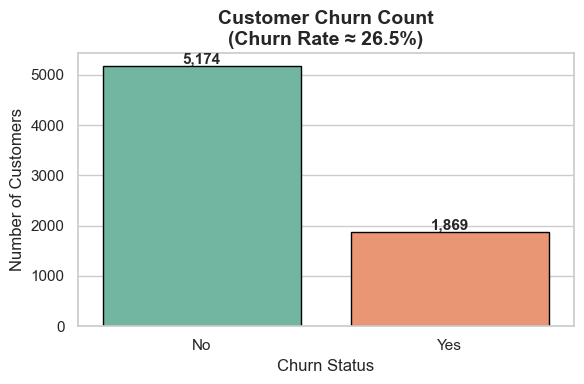

In [47]:
plt.figure(figsize=(6,4))

# Plot with custom colors and edge for clarity
ax = sns.barplot(
    data=churn_df,
    x="Churn",
    y="count",
    hue="Churn",              
    palette="Set2",
    dodge=False,
    edgecolor="black"
)

# Add count labels on each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height):,}',             
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold')

# Compute and display churn rate inside the title
churn_rate = (churn_df.loc[churn_df['Churn']=='Yes','count'].iloc[0] /
              churn_df['count'].sum()) * 100

plt.title(f"Customer Churn Count\n(Churn Rate ≈ {churn_rate:.1f}%)",
          fontsize=14, weight='bold')
plt.xlabel("Churn Status")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()


**Insight**: Out of 7,043 total customers, 1,869 (≈26.5%) have churned while 5,174 (≈73.5%) remain.
This establishes the overall churn rate that future analyses can benchmark.

**Average monthly charge by contract type**

In [45]:
contract_df = pd.read_sql("""
    SELECT Contract,
           ROUND(AVG(MonthlyCharges), 2) AS avg_monthly
    FROM Customers
    GROUP BY Contract
    ORDER BY avg_monthly DESC;
""", conn)
display(contract_df)

,Contract,avg_monthly
0,Month-to-month,66.40
1,One year,65.05
2,Two year,60.77


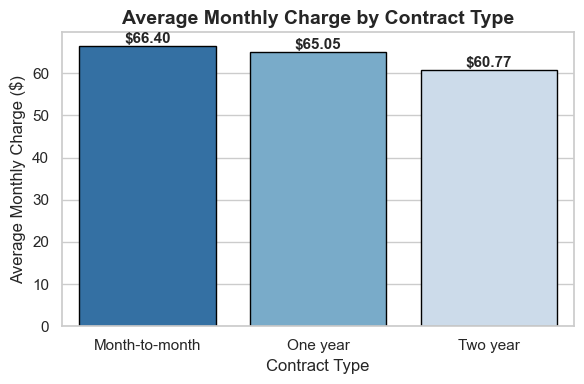

In [48]:
plt.figure(figsize=(6,4))

ax = sns.barplot(
    data=contract_df,
    x="Contract",
    y="avg_monthly",
    hue="Contract",       
    palette="Blues_r",
    dodge=False,
    edgecolor="black"
)


for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"${height:.2f}",
                (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold')

plt.title("Average Monthly Charge by Contract Type", fontsize=14, weight='bold')
plt.xlabel("Contract Type")
plt.ylabel("Average Monthly Charge ($)")
plt.tight_layout()
plt.show()


**Insight:**
- Month-to-month customers pay the highest average monthly fee (~$66.40)
  
- One-year customers average ~$65.05.

  
- Two-year customers pay the lowest (~$60.77).
  
Short-term contracts carry higher prices, which may motivate cost-sensitive customers to leave.

**Churn rate by Internet Service type**

In [49]:
internet_df = pd.read_sql("""
    SELECT InternetService,
           ROUND(100.0 * SUM(Churn='Yes') / COUNT(*), 2) AS churn_rate
    FROM Customers
    GROUP BY InternetService
    ORDER BY churn_rate DESC;
""", conn)


display(internet_df)

,InternetService,churn_rate
0,Fiber optic,41.89
1,DSL,18.96
2,No,7.40


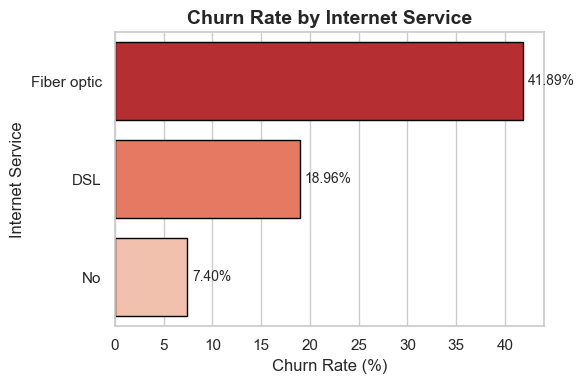

In [50]:
# Plot
plt.figure(figsize=(6,4))
sns.barplot(
    data=internet_df,
    x="churn_rate",
    y="InternetService",
    hue="InternetService",  
    palette="Reds_r",
    dodge=False,
    edgecolor="black"
)

# Add value labels on each bar
for p in plt.gca().patches:
    width = p.get_width()
    plt.gca().annotate(f"{width:.2f}%",
                        (width + 0.5, p.get_y() + p.get_height()/2),
                        ha='left', va='center', fontsize=10)

plt.title("Churn Rate by Internet Service", fontsize=14, weight="bold")
plt.xlabel("Churn Rate (%)")
plt.ylabel("Internet Service")
plt.tight_layout()
plt.show()


**Insight** :
- Fiber optic customers have the highest churn rate (~41.9%),

- followed by DSL (~19%),

- while customers with no internet service churn the least (~7.4%).

  
Fiber optic users are churning at more than twice the rate of DSL customers, signaling potential issues with price, service quality, or competition.

**Total monthly revenue lost from churned customers**

In [20]:
pd.read_sql("""
SELECT ROUND(SUM(MonthlyCharges), 2) AS lost_revenue
FROM Customers
WHERE Churn='Yes';
""", conn)

,lost_revenue
0,139130.85


**Insight:**
The company is losing ≈ $139,130.85 in monthly recurring revenue from customers who have already churned.
This is a significant ongoing loss and highlights the value of proactive retention strategies.

**Rank the highest lifetime value customers who churned**

In [21]:
pd.read_sql("""
SELECT CustomerID,
       TotalCharges,
       RANK() OVER (ORDER BY TotalCharges DESC) AS revenue_rank
FROM Customers
WHERE Churn='Yes'
LIMIT 10;
""", conn)

,customerID,TotalCharges,revenue_rank
0,2889-FPWRM,8684.80,1
1,0201-OAMXR,8127.60,2
2,3886-CERTZ,8109.80,3
3,1444-VVSGW,7968.85,4
4,5271-YNWVR,7856.00,5
5,8199-ZLLSA,7804.15,6
6,9053-JZFKV,7752.30,7
7,1555-DJEQW,7723.90,8
8,3259-FDWOY,7723.70,9
9,7317-GGVPB,7690.90,10


**Insight:**
The top 10 churned customers each generated $7,600–$8,700 in lifetime revenue before leaving.
Losing high-value customers like these has a disproportionate impact on total revenue and underscores the need for targeted retention of premium accounts.

**Segment customers by churn risk**

In [22]:
pd.read_sql("""
WITH Risk AS (
    SELECT CustomerID,
           CASE
               WHEN Tenure < 12 AND MonthlyCharges > 80 THEN 'High Risk'
               WHEN Tenure < 24 AND MonthlyCharges BETWEEN 50 AND 80 THEN 'Medium Risk'
               ELSE 'Low Risk'
           END AS RiskCategory
    FROM Customers
)
SELECT RiskCategory,
       COUNT(*) AS customer_count,
       ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM Customers), 2) AS pct
FROM Risk
GROUP BY RiskCategory;
""", conn)

,RiskCategory,customer_count,pct
0,High Risk,439,6.23
1,Low Risk,5521,78.39
2,Medium Risk,1083,15.38


**Insight:**

- High Risk: 439 customers (≈ 6.2%) are new (<12 months) and pay > $80/month—prime targets for churn-prevention campaigns.

- Medium Risk: 1,083 customers (≈ 15.4%) have moderate tenure and charges.

- Low Risk: 5,521 customers (≈ 78.4%) are relatively stable.

These segments help prioritize outreach and retention resources.

### 6. Views

This view combines Contract type and Internet Service to show average charges, tenure, and churn rate.

In [ ]:
conn.execute("""
CREATE VIEW IF NOT EXISTS v_ChurnSummary AS
SELECT Contract,
       InternetService,
       ROUND(AVG(MonthlyCharges),2) AS avg_monthly,
       ROUND(AVG(Tenure),1) AS avg_tenure,
       ROUND(100.0 * SUM(Churn='Yes') / COUNT(*), 2) AS churn_rate
FROM Customers
GROUP BY Contract, InternetService;
""")
conn.commit()


In [24]:
pd.read_sql("SELECT * FROM v_ChurnSummary ORDER BY churn_rate DESC;", conn)


,Contract,InternetService,avg_monthly,avg_tenure,churn_rate
0,Month-to-month,Fiber optic,87.02,21.6,54.61
1,Month-to-month,DSL,50.22,15.7,32.22
2,One year,Fiber optic,98.78,52.1,19.29
3,Month-to-month,No,20.41,9.1,18.89
4,One year,DSL,61.40,40.5,9.30
5,Two year,Fiber optic,104.57,65.2,7.23
6,One year,No,20.82,29.6,2.47
7,Two year,DSL,70.46,59.1,1.91
8,Two year,No,21.78,48.7,0.78


**Insight:**

- Highest risk: Month-to-month + Fiber optic customers churn the most (≈54.6%) despite high monthly charges (\~\$87) and short tenure (\~22 months).
- Moderate risk: Month-to-month + DSL churn ≈32%; One-year + Fiber optic ≈19%.
- Lowest risk: Two-year contracts across all services have churn below 2% and the longest tenures, showing that long-term contracts strongly improve retention.


### 8. Key Insights

### Key Insights (Overall)

* **Overall Churn Rate:** About **26.5% of customers (1,869 out of 7,043)** have churned, representing a significant loss of recurring revenue.

* **Revenue Impact:** Churned customers account for roughly **\$139,000 in monthly revenue loss**, highlighting the financial urgency of retention.

* **Contract Type:**

  * **Month-to-month contracts** show the highest churn and the highest average monthly charge (\~\$66), indicating price sensitivity and low commitment.
  * **One-year and Two-year contracts** have far lower churn rates, with **Two-year plans below 2%**, proving that longer terms dramatically reduce attrition.

* **Internet Service:**

  * **Fiber optic customers** churn the most (≈42% overall), even though they often pay more.
  * **DSL** churn is moderate (\~19%), while customers with **no internet service** churn the least (\~7%).

* **High-Value Losses:** Several churned customers generated **\$7,600–\$8,700** in lifetime revenue each, meaning the company is losing not just many customers but also some of its most profitable ones.

* **Risk Segmentation:**

  * **High-risk group (\~6% of customers)** are new (<12 months) and pay >\$80/month.
  * **Medium risk (\~15%)** have moderate tenure and charges.
  * **Low risk (\~79%)** are long-tenure or lower-charge customers.

* **Combined View:**

  * **Month-to-month + Fiber optic** customers are the single riskiest segment (≈55% churn) despite high bills (\~\$87).
  * Two-year contracts across all services combine **high revenue with very low churn**, confirming long-term plans as the strongest retention lever.

These findings suggest that **retention efforts should focus on high-value, short-tenure customers—especially those on month-to-month Fiber optic plans—while promoting long-term contracts to stabilize revenue.**
